In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
import xgboost
from imblearn.over_sampling import SMOTE


pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 20)

In [25]:
df = pd.read_csv("./Data/NLP_all_targets.csv", index_col=0)
df.head()

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,target
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0,1.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0,2.0
2,swonderlin wait ipad also sale sxsw,1.0,0.0,0.0,2.0
3,sxsw hope year's festival crashy year's iphone...,1.0,0.0,0.0,1.0
4,sxtxstate great stuff fri sxsw marissa mayer g...,0.0,1.0,0.0,2.0


### Original DF prior to tokenization - displaying original format/class target values

In [26]:
original_df = pd.read_csv("./Data/clean_tweets.csv", index_col=0)
original_df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0


In [27]:
original_df.shape

(8936, 6)

In [28]:
original_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [29]:
original_df['target'].value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

# Creating the OVR target columns

### No emotion = 0
### Negative = 1
### Positive = 2

In [30]:
df.shape

(8936, 5)

In [31]:
# For negative one vs rest
df["OVR-Negative"] = df["target"].apply(lambda x: 1 if x == 1 else 0)

# For positive one vs rest
df["OVR-Positive"] = df["target"].apply(lambda x: 1 if x == 2 else 0)

### After adding the OVR columns

In [32]:
df.shape

(8936, 7)

In [33]:
df.head()

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,target,OVR-Negative,OVR-Positive
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0,1.0,1,0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0,2.0,0,1
2,swonderlin wait ipad also sale sxsw,1.0,0.0,0.0,2.0,0,1
3,sxsw hope year's festival crashy year's iphone...,1.0,0.0,0.0,1.0,1,0
4,sxtxstate great stuff fri sxsw marissa mayer g...,0.0,1.0,0.0,2.0,0,1


# Creating separate target DF's for positive/negative OVR
We want to establish new dataframe objects for each given target relationship to make for speedy iterative modeling.

In [34]:
# Target, features for positive ovr
X_positive = df.drop(columns=["target", "OVR-Negative", "OVR-Positive"]).copy()
y_positive = df["OVR-Positive"].copy()

# Target, features for negative ovr
X_negative = df.drop(columns=["target", "OVR-Positive", "OVR-Negative"]).copy()
y_negative = df["OVR-Negative"].copy()

### Sanity Check

In [35]:
X_positive.shape, X_negative.shape, y_positive.shape, y_negative.shape

((8936, 4), (8936, 4), (8936,), (8936,))

In [36]:
X_positive.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0


In [37]:
y_positive[:5]

0    0
1    1
2    1
3    0
4    1
Name: OVR-Positive, dtype: int64

In [38]:
X_negative.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0


In [39]:
y_negative[:5]

0    1
1    0
2    0
3    1
4    0
Name: OVR-Negative, dtype: int64

The different y's for pos/neg are effectively the opposite of one another. 

# Tokenization and Vectorization

Because we have imported a csv with the already lemmatized and tokenized strings, we do not need to include that step here. The only things we need to do are to vectorize the text data. We will vectorize the data using both Count Vectorization and TF-IDF Vectorization and compare the performance of models using the different factors. 

### Class for data tracking
This is the same class creation that we have used in other notebooks. It essentially encapsulates the different attributes, metrics, and plots that we want to have access to after creating the various models. 

# REMINDER:
If you want to change from positive/negative OVR modeling, it is important to either re-run this class definition cell to refresh the DF containing model metrics, or be very accurate in terms of how you name your models so that they are easily distinguished from one another.

In [40]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr)
        ax.set_title(f"{self.name} ROC Curve");
        
    def compare_roc_curve(self):
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=26)
        # Create the plot
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right');
    
    def confusion_matrix(self):
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title(f"Confusion Matrix for {self.name} Test Data");
    
    
    def __repr__(self):
      return f"Model name: {self.name}"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

### Train/Test Split on the Data
We are performing a train/test split on our data prior to the vectorization of tokens. This is a step taken in order to prevent data leakage. We will also set "stratify=y" due to the imbalanced nature of the data.

# PERFORM FOR X_POSITIVE/X_NEGATIVE SEPARATELY
### REMINDER: Re-run class definition cell to reset Model.model_df

In [41]:
# Train test split on the data, stratifying because of the relative imbalance of the data
X_train, X_test, y_train, y_test = train_test_split(X_positive, y_positive, random_state=42, stratify=y_positive)

# initially did X_positive, y_positive, then X_negative, y_negative

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6702, 4), (2234, 4), (6702,), (2234,))

In [43]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Count Vectorizer
count_vectorizer = CountVectorizer()

### Function to concatenate vectorized text back with the rest of its respective X variable

In [44]:
# Will vectorize tokenized data, and recombine it with our original X_train/test
def combine_train_vectorization(X, column, vectorizer):
    vector = vectorizer.fit_transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

def combine_test_vectorization(X, column, vectorizer):
    vector = vectorizer.transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)


### Vectorizations
Here, we make use of the function defined above to transform our tokens into vectorized data. 

In [45]:
# TF-IDF Vectorized Version of the X_train DataFrame
X_train_tfidf = combine_train_vectorization(X_train, "tokens", tfidf)
X_test_tfidf = combine_test_vectorization(X_test, "tokens", tfidf)

In [46]:
# Count Vectorized Version of X_train DataFrame
X_train_count = combine_train_vectorization(X_train, "tokens", count_vectorizer)
X_test_count = combine_test_vectorization(X_test, "tokens", count_vectorizer)

# TFIDF Data

In [48]:
X_train_count.shape, X_test_count.shape

((6702, 6825), (2234, 6825))

In [47]:
X_train_tfidf.shape, X_test_tfidf.shape

((6702, 6825), (2234, 6825))

In [49]:
X_train_tfidf.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,aaron,aarpbulletin,ab,abacus,abba,abc,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Verifying the nature of the target column

In [52]:
y_positive[1073], y_negative[1073]

(1, 0)

In [51]:
y_train[15:25]

3354    0
7981    0
6213    0
1073    1
3632    0
2323    0
5493    0
1434    0
8871    0
6795    0
Name: OVR-Positive, dtype: int64

# COUNT Data

In [53]:
X_test_count.shape

(2234, 6825)

In [54]:
X_train_count.shape

(6702, 6825)

In [55]:
X_train_count.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,aaron,aarpbulletin,ab,abacus,abba,abc,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
y_train[:2]

7585    0
216     1
Name: OVR-Positive, dtype: int64

### SMOTE

In [57]:
# TF-IDF vector Smote
smote1 = SMOTE(random_state=42)
X_train_smote_tfidf, y_smote_tfidf = smote1.fit_resample(X_train_tfidf, y_train)

# Count Vector Smote
smote2 = SMOTE(random_state=42)
X_train_smote_count, y_smote_count = smote2.fit_resample(X_train_count, y_train)

# Variable Pairs:
## TFIDF
- X_train_tfidf | y_train
- X_test_tfidf | y_test
##### Smote
- X_train_smote_tfidf | y_smote_tfidf
- X_test_tfidf | y_test

## COUNT
- X_train_count | y_train
- X_test_count | y_test
##### Smote
- X_train_smote_count | y_smote_count
- X_test_count | y_test

# Model Iterations:
Because we had already gone through this process in the exclusively binary modeling notebook, we had much of the code ready to go. 

# DUMMY MODEL FIRST

In [59]:
# Dummy model instantiation
dummy = DummyClassifier(strategy="most_frequent")

# Transformation doesn't matter because it is the dummy model
dummy.fit(X_train_tfidf, y_train)

# Class object instantiation
dummy_0 = Model("Dummy", dummy, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


In [60]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.0,0.0,0.0,12.014551,0.666965,0.0,0.0,0.0,12.003795,0.5


In [62]:
y_train.value_counts(normalize=True)

0    0.666667
1    0.333333
Name: OVR-Positive, dtype: float64

In [65]:
y_test.value_counts(normalize=True)

0    0.666965
1    0.333035
Name: OVR-Positive, dtype: float64

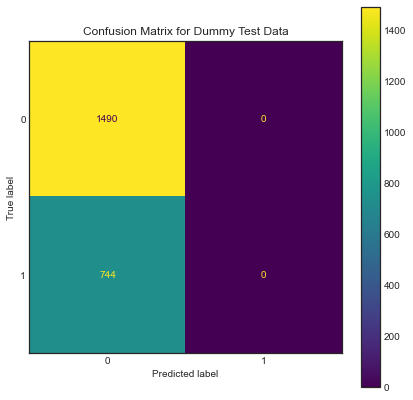

In [66]:
plt.style.use('seaborn-white')
dummy_0.confusion_matrix()

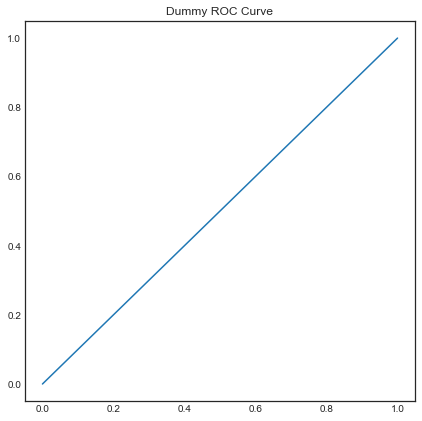

In [67]:
dummy_0.roc_curve()

# Logistic Regression

In [68]:
# Classifier Objects

# TFIDF
lr_tfidf = LogisticRegression(random_state=42, n_jobs=-4)

# COUNT
lr_count = LogisticRegression(random_state=42, n_jobs=-4)

# SMOTE TFIDF
lr_tfidf_smote = LogisticRegression(random_state=42, n_jobs=-4)

# SMOTE COUNT
lr_count_smote = LogisticRegression(random_state=42, n_jobs=-4)


# Fitting each of the models 

# TFIDF natural
lr_tfidf.fit(X_train_tfidf, y_train)

# COUNT natural
lr_count.fit(X_train_count, y_train)

# TFIDF w SMOTE
lr_tfidf_smote.fit(X_train_smote_tfidf, y_smote_tfidf)

# COUNT w SMOTE
lr_count_smote.fit(X_train_smote_count, y_smote_count)

LogisticRegression(n_jobs=-4, random_state=42)

In [69]:
# Class Model object instantiation

#TF-IDF model object
lr_TF = Model("Logistic TF-IDF", lr_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# COUNT model object
lr_C = Model("Logistic Count-Vect", lr_count, count_vectorizer, X_train_count, X_test_count, y_train, y_test)

# TFIDF Smote model object
lr_TF_S = Model("Logistic TF-IDF Smote", lr_tfidf_smote, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

# COUNT Smote model object
lr_C_S = Model("Logistic Count Smote", lr_count_smote, count_vectorizer, X_train_smote_count, X_test_count, y_smote_count, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   21.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   28.7s finished


In [70]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.000000,0.000000,0.000000,12.014551,0.666965,0.000000,0.000000,0.000000,12.003795,0.500000
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
3,Logistic TF-IDF Smote,0.765447,0.747539,0.800796,0.772230,0.499237,0.733214,0.583900,0.692204,0.633456,0.536067,0.791996
4,Logistic Count Smote,0.754710,0.737353,0.782422,0.752863,0.530323,0.689794,0.530178,0.602151,0.563877,0.594250,0.750590


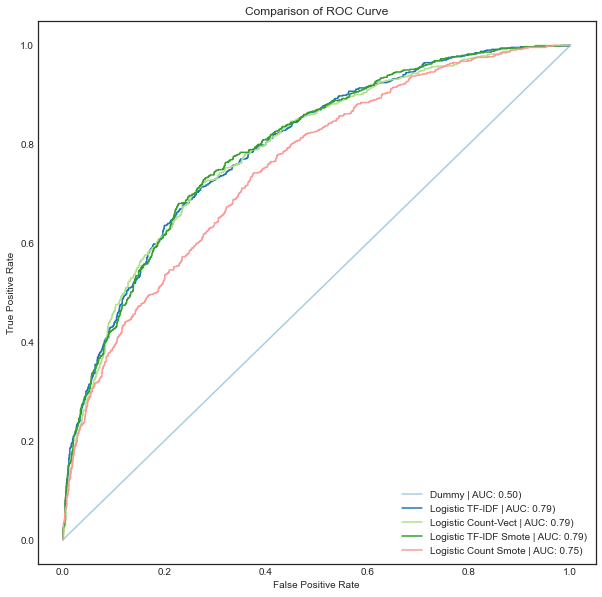

In [71]:
plt.style.use("seaborn-white")
lr_C.compare_roc_curve()

# Naive Bayes

In [72]:
# Classifier Objects

# TFIDF
mnb_tfidf = MultinomialNB()

# COUNT
mnb_count = MultinomialNB()

# SMOTE TFIDF
mnb_tfidf_smote = MultinomialNB()

# SMOTE COUNT
mnb_count_smote = MultinomialNB()


# Fitting each of the models 

# TFIDF natural
mnb_tfidf.fit(X_train_tfidf, y_train)

# COUNT natural
mnb_count.fit(X_train_count, y_train)

# TFIDF w SMOTE
mnb_tfidf_smote.fit(X_train_smote_tfidf, y_smote_tfidf)

# COUNT w SMOTE
mnb_count_smote.fit(X_train_smote_count, y_smote_count)

MultinomialNB()

In [73]:
# Class Model object instantiation

#TF-IDF model object
mnb_TF = Model("Naive Bayes TF-IDF", mnb_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# COUNT model object
mnb_C = Model("Naive Bayes Count-Vect", mnb_count, count_vectorizer, X_train_count, X_test_count, y_train, y_test)

# TFIDF Smote model object
mnb_TF_S = Model("Naive Bayes TF-IDF Smote", mnb_tfidf_smote, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

# COUNT Smote model object
mnb_C_S = Model("Naive Bayes Count Smote", mnb_count_smote, count_vectorizer, X_train_smote_count, X_test_count, y_smote_count, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.9s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classifica

In [74]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.000000,0.000000,0.000000,12.014551,0.666965,0.000000,0.000000,0.000000,12.003795,0.500000
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
3,Logistic TF-IDF Smote,0.765447,0.747539,0.800796,0.772230,0.499237,0.733214,0.583900,0.692204,0.633456,0.536067,0.791996
4,Logistic Count Smote,0.754710,0.737353,0.782422,0.752863,0.530323,0.689794,0.530178,0.602151,0.563877,0.594250,0.750590
5,Naive Bayes TF-IDF,0.703224,0.682387,0.205462,0.315508,0.564890,0.713518,0.734234,0.219086,0.337474,0.557214,0.756432
6,Naive Bayes Count-Vect,0.702032,0.555533,0.529553,0.541810,0.740107,0.723366,0.601286,0.502688,0.547584,0.705660,0.753735
7,Naive Bayes TF-IDF Smote,0.723144,0.674521,0.862348,0.756661,0.524734,0.662041,0.495180,0.759409,0.599469,0.581092,0.767473
8,Naive Bayes Count Smote,0.707592,0.678965,0.782893,0.725371,0.738530,0.666965,0.500000,0.676075,0.574857,0.800492,0.742799


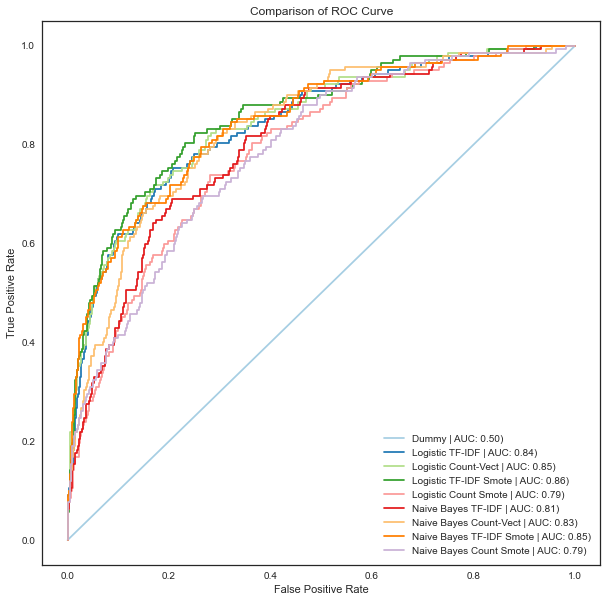

In [157]:
lr_C.compare_roc_curve()

# Random Forest Classifer

In [ ]:
# for reference

# rndm_tfidf = RandomForestClassifier(random_state=42)
# rndm_tfidf.fit(X_train_transformed, y_train)

In [158]:
# Classifier Objects

# TFIDF
RF_tfidf = RandomForestClassifier(random_state=42)

# COUNT
RF_count = RandomForestClassifier(random_state=42)

# SMOTE TFIDF
RF_tfidf_smote = RandomForestClassifier(random_state=42)

# SMOTE COUNT
RF_count_smote = RandomForestClassifier(random_state=42)


# Fitting each of the models 

# TFIDF natural
RF_tfidf.fit(X_train_tfidf, y_train)

# COUNT natural
RF_count.fit(X_train_count, y_train)

# TFIDF w SMOTE
RF_tfidf_smote.fit(X_train_smote_tfidf, y_smote_tfidf)

# COUNT w SMOTE
RF_count_smote.fit(X_train_smote_count, y_smote_count)

RandomForestClassifier(random_state=42)

In [159]:
# Class Model object instantiation

#TF-IDF model object
RF_TF = Model("Random Forest TF-IDF", RF_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# COUNT model object
RF_C = Model("Random Forest Count-Vect", RF_count, count_vectorizer, X_train_count, X_test_count, y_train, y_test)

# TFIDF Smote model object
RF_TF_S = Model("Random Forest TF-IDF Smote", RF_tfidf_smote, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

# COUNT Smote model object
RF_C_S = Model("Random Forest Count Smote", RF_count_smote, count_vectorizer, X_train_smote_count, X_test_count, y_smote_count, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   21.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   32.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   47.9s finished


In [160]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.936139,0.000000,0.000000,0.000000,2.301800,0.936437,0.000000,0.000000,0.000000,2.291047,0.500000
1,Logistic TF-IDF,0.935840,0.200000,0.002353,0.004651,0.193716,0.937780,0.800000,0.028169,0.054422,0.188002,0.841314
2,Logistic Count-Vect,0.938526,0.585377,0.137811,0.220956,0.184884,0.943151,0.659574,0.218310,0.328042,0.178534,0.846313
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
5,Naive Bayes TF-IDF,0.936139,0.000000,0.000000,0.000000,0.297099,0.936437,0.000000,0.000000,0.000000,0.293382,0.805507
6,Naive Bayes Count-Vect,0.918084,0.265617,0.161286,0.199881,0.414558,0.937780,0.534884,0.161972,0.248649,0.345802,0.834369
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
8,Naive Bayes Count Smote,0.910905,0.889296,0.938004,0.911569,0.354527,0.879588,0.234310,0.394366,0.293963,0.393100,0.787817
9,Random Forest TF-IDF,0.940019,0.651043,0.130862,0.216136,0.331604,0.944047,0.774194,0.169014,0.277457,0.279951,0.822372


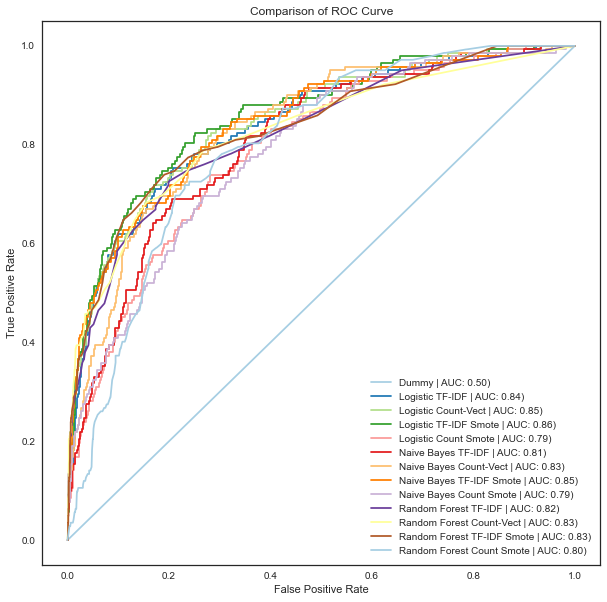

In [161]:
lr_C.compare_roc_curve()

# AdaBoost

In [162]:
# Classifier Objects

# TFIDF
ADA_tfidf = AdaBoostClassifier(random_state=42)

# COUNT
ADA_count = AdaBoostClassifier(random_state=42)

# SMOTE TFIDF
ADA_tfidf_smote = AdaBoostClassifier(random_state=42)

# SMOTE COUNT
ADA_count_smote = AdaBoostClassifier(random_state=42)


# Fitting each of the models 

# TFIDF natural
ADA_tfidf.fit(X_train_tfidf, y_train)

# COUNT natural
ADA_count.fit(X_train_count, y_train)

# TFIDF w SMOTE
ADA_tfidf_smote.fit(X_train_smote_tfidf, y_smote_tfidf)

# COUNT w SMOTE
ADA_count_smote.fit(X_train_smote_count, y_smote_count)

AdaBoostClassifier(random_state=42)

In [163]:
# Class Model object instantiation

#TF-IDF model object
ADA_TF = Model("AdaBoost TF-IDF", ADA_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# COUNT model object
ADA_C = Model("AdaBoost Count-Vect", ADA_count, count_vectorizer, X_train_count, X_test_count, y_train, y_test)

# TFIDF Smote model object
ADA_TF_S = Model("AdaBoost TF-IDF Smote", ADA_tfidf_smote, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

# COUNT Smote model object
ADA_C_S = Model("AdaBoost Count Smote", ADA_count_smote, count_vectorizer, X_train_smote_count, X_test_count, y_smote_count, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   45.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   44.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.4min finished


In [164]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.936139,0.000000,0.000000,0.000000,2.301800,0.936437,0.000000,0.000000,0.000000,2.291047,0.500000
1,Logistic TF-IDF,0.935840,0.200000,0.002353,0.004651,0.193716,0.937780,0.800000,0.028169,0.054422,0.188002,0.841314
2,Logistic Count-Vect,0.938526,0.585377,0.137811,0.220956,0.184884,0.943151,0.659574,0.218310,0.328042,0.178534,0.846313
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
5,Naive Bayes TF-IDF,0.936139,0.000000,0.000000,0.000000,0.297099,0.936437,0.000000,0.000000,0.000000,0.293382,0.805507
6,Naive Bayes Count-Vect,0.918084,0.265617,0.161286,0.199881,0.414558,0.937780,0.534884,0.161972,0.248649,0.345802,0.834369
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
8,Naive Bayes Count Smote,0.910905,0.889296,0.938004,0.911569,0.354527,0.879588,0.234310,0.394366,0.293963,0.393100,0.787817
9,Random Forest TF-IDF,0.940019,0.651043,0.130862,0.216136,0.331604,0.944047,0.774194,0.169014,0.277457,0.279951,0.822372


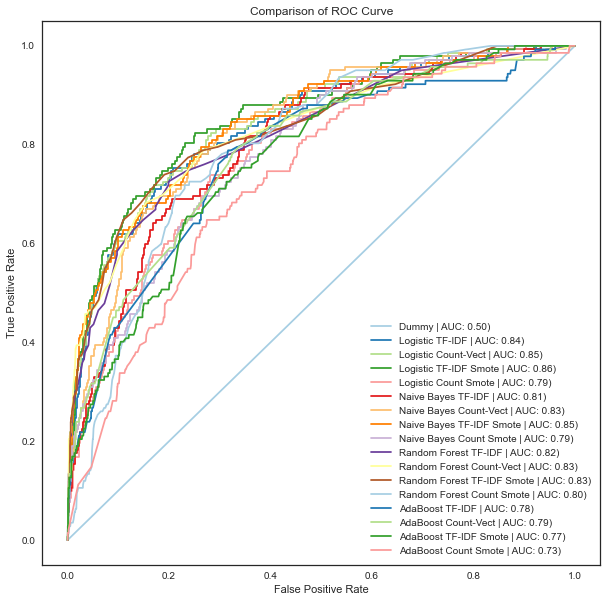

In [165]:
lr_C.compare_roc_curve()

# XGBoost

In [ ]:
[logistic, naive bayes, liblinear, and xgboost]

In [75]:
# Classifier Objects
from xgboost import XGBClassifier
# TFIDF
XGB_tfidf = XGBClassifier(random_state=42)

# COUNT
XGB_count = XGBClassifier(random_state=42)

# SMOTE TFIDF
XGB_tfidf_smote = XGBClassifier(random_state=42)

# SMOTE COUNT
XGB_count_smote = XGBClassifier(random_state=42)


# Fitting each of the models 

# TFIDF natural
XGB_tfidf.fit(X_train_tfidf, y_train)

# COUNT natural
XGB_count.fit(X_train_count, y_train)

# TFIDF w SMOTE
XGB_tfidf_smote.fit(X_train_smote_tfidf, y_smote_tfidf)

# COUNT w SMOTE
XGB_count_smote.fit(X_train_smote_count, y_smote_count)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
# Class model object instantiation

#TF-IDF model object
XGB_TF = Model("XGBoost TF-IDF", XGB_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# COUNT model object
XGB_C = Model("XGBoost Count-Vect", XGB_count, count_vectorizer, X_train_count, X_test_count, y_train, y_test)

# TFIDF Smote model object
XGB_TF_S = Model("XGBoost TF-IDF Smote", XGB_tfidf_smote, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

# COUNT Smote model object
XGB_C_S = Model("XGBoost Count Smote", XGB_count_smote, count_vectorizer, X_train_smote_count, X_test_count, y_smote_count, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  7.3min finished


# CAUTION CAUTION CAUTION - skip to correct OVR section

# Proceed cautiously from here to preserve Postive OVR and Negative OVR

# I goofed up the naming on the first pass

In [92]:
Model.model_df.loc[17, "name"] = "XGBoost TF-IDF"
Model.model_df.loc[18, "name"] = "XGBoost Count-Vect"
Model.model_df.loc[19, "name"] = "XGBoost TF-IDF Smote"
Model.model_df.loc[20, "name"] = "XGBoost Count Smote"

In [89]:
XGB_TF.name = "XGBoost TF-IDF"
XGB_C.name = "XGBoost Count-Vect"
XGB_TF_S.name = "XGBoost TF-IDF Smote"
XGB_C_S.name = "XGBoost Count Smote"

In [78]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.000000,0.000000,0.000000,12.014551,0.666965,0.000000,0.000000,0.000000,12.003795,0.500000
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
3,Logistic TF-IDF Smote,0.765447,0.747539,0.800796,0.772230,0.499237,0.733214,0.583900,0.692204,0.633456,0.536067,0.791996
4,Logistic Count Smote,0.754710,0.737353,0.782422,0.752863,0.530323,0.689794,0.530178,0.602151,0.563877,0.594250,0.750590
5,Naive Bayes TF-IDF,0.703224,0.682387,0.205462,0.315508,0.564890,0.713518,0.734234,0.219086,0.337474,0.557214,0.756432
6,Naive Bayes Count-Vect,0.702032,0.555533,0.529553,0.541810,0.740107,0.723366,0.601286,0.502688,0.547584,0.705660,0.753735
7,Naive Bayes TF-IDF Smote,0.723144,0.674521,0.862348,0.756661,0.524734,0.662041,0.495180,0.759409,0.599469,0.581092,0.767473
8,Naive Bayes Count Smote,0.707592,0.678965,0.782893,0.725371,0.738530,0.666965,0.500000,0.676075,0.574857,0.800492,0.742799
9,XGBoost TF-IDF,0.739782,0.686771,0.403771,0.507874,0.526794,0.739481,0.689252,0.396505,0.503413,0.528332,0.771444


In [96]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
18,XGBoost Count-Vect,0.742319,0.693660,0.406906,0.512137,0.517572,0.742614,0.706601,0.388441,0.501301,0.521305,0.778349
17,XGBoost TF-IDF,0.739782,0.686771,0.403771,0.507874,0.526794,0.739481,0.689252,0.396505,0.503413,0.528332,0.771444
9,Random Forest TF-IDF,0.742317,0.715644,0.377360,0.493411,0.546722,0.739033,0.688525,0.395161,0.502135,0.558885,0.773991


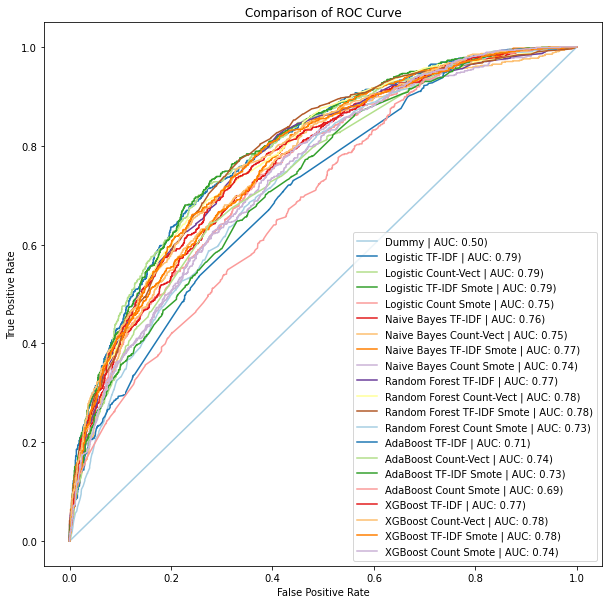

In [97]:
lr_C.compare_roc_curve()

# Liblinear Logistic Regression

Logistic Regression models with count vectorization and tf-idf performed the best for test accuracy. I will quickly create model objects with different solvers for those two models. 

In [79]:
# TFIDF
lr_tfidf_final = LogisticRegression(solver='liblinear')

# COUNT 
lr_count_final = LogisticRegression(solver='liblinear')


# TFIDF natural
lr_tfidf_final.fit(X_train_tfidf, y_train)

# COUNT natural
lr_count_final.fit(X_train_count, y_train)


LogisticRegression(solver='liblinear')

### Final model additions based on my experience from the binary df modeling

In [80]:
LR_TFIDF_FINAL = Model("LR Liblinear TFIDF", lr_tfidf_final, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

LR_COUNT_FINAL = Model("LR Liblinear COUNT", lr_count_final, tfidf, X_train_count, X_test_count, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.5s finished


In [81]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.000000,0.000000,0.000000,12.014551,0.666965,0.000000,0.000000,0.000000,12.003795,0.500000
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
3,Logistic TF-IDF Smote,0.765447,0.747539,0.800796,0.772230,0.499237,0.733214,0.583900,0.692204,0.633456,0.536067,0.791996
4,Logistic Count Smote,0.754710,0.737353,0.782422,0.752863,0.530323,0.689794,0.530178,0.602151,0.563877,0.594250,0.750590
5,Naive Bayes TF-IDF,0.703224,0.682387,0.205462,0.315508,0.564890,0.713518,0.734234,0.219086,0.337474,0.557214,0.756432
6,Naive Bayes Count-Vect,0.702032,0.555533,0.529553,0.541810,0.740107,0.723366,0.601286,0.502688,0.547584,0.705660,0.753735
7,Naive Bayes TF-IDF Smote,0.723144,0.674521,0.862348,0.756661,0.524734,0.662041,0.495180,0.759409,0.599469,0.581092,0.767473
8,Naive Bayes Count Smote,0.707592,0.678965,0.782893,0.725371,0.738530,0.666965,0.500000,0.676075,0.574857,0.800492,0.742799
9,XGBoost TF-IDF,0.739782,0.686771,0.403771,0.507874,0.526794,0.739481,0.689252,0.396505,0.503413,0.528332,0.771444


# Final Top 5 Positive Sentiment Identification One V Rest

In [100]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
22,LR Liblinear COUNT,0.740227,0.643362,0.496871,0.559925,0.531629,0.754252,0.668977,0.518817,0.584406,0.525488,0.786819
2,Logistic Count-Vect,0.740078,0.643554,0.495079,0.558855,0.531679,0.753805,0.668403,0.517473,0.583333,0.525166,0.787201
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
21,LR Liblinear TFIDF,0.736199,0.686535,0.384069,0.492072,0.518146,0.743509,0.695652,0.408602,0.514818,0.511983,0.790627
18,XGBoost Count-Vect,0.742319,0.693660,0.406906,0.512137,0.517572,0.742614,0.706601,0.388441,0.501301,0.521305,0.778349


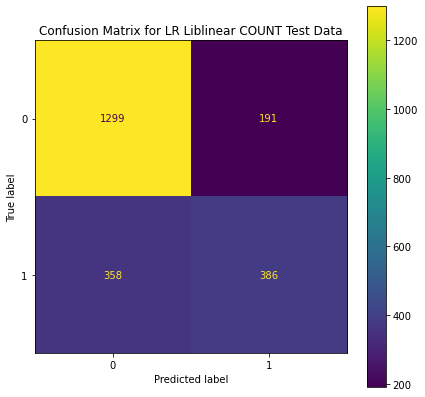

In [101]:
LR_COUNT_FINAL.confusion_matrix()

In [108]:
type(XGB_C)

__main__.Model

In [ ]:
# list of top models = 
top_models = [LR_COUNT_FINAL, lr_C, lr_TF, LR_TFIDF_FINAL, XGB_C]

# FOR POSITIVE ONE VS REST DATA

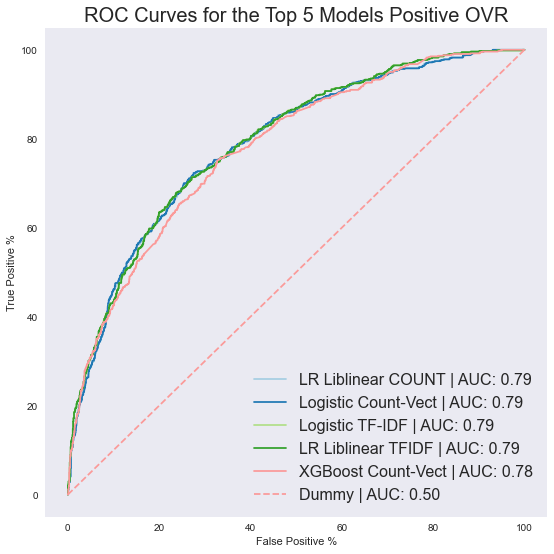

In [109]:
# Plotting the top 5 Models by accuracy against the dummy model
plt.style.use('seaborn')
# List of custom class model objects
top_models = [LR_COUNT_FINAL, lr_C, lr_TF, LR_TFIDF_FINAL, XGB_C]
color = sns.color_palette("Paired")
fig, ax = plt.subplots(figsize=(9,9))
for num, i in enumerate(top_models):
    y_hat_hd = i.y_pred_proba[:, 1]
    tpr, fpr, _ = roc_curve(i.y_test, y_hat_hd)
    ax.plot(tpr, fpr, color=color[num], label=f"{i.name} | AUC: {i.auc:.2f}")
ax.legend()
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_xticks([0, .2, .4, .6, .8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("True Positive %")
ax.set_xlabel("False Positive %")
ax.set_title("ROC Curves for the Top 5 Models Positive OVR", fontsize=20)

y_hat_hd = dummy_0.y_pred_proba[:, 1]
tpr, fpr, _ = roc_curve(dummy_0.y_test, y_hat_hd)
ax.plot(tpr, fpr, color=color[num], label=f"{dummy_0.name} | AUC: {dummy_0.auc:.2f}", linestyle="--")
plt.grid(False)
ax.legend(bbox_to_anchor=(.5,.3))
plt.legend(fontsize=16);

In [111]:
positive_OVR = Model.model_df.copy()

In [112]:
positive_OVR.head(2)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.000000,0.000000,0.000000,12.014551,0.666965,0.000000,0.000000,0.000000,12.003795,0.500000
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701


In [113]:
positive_OVR.to_csv("/Users/samalainabayeva/Desktop/Water Project CSVs/positive_OVR.csv")

# Best accuracy model (LR Liblinear) 4% less precise than most precise model. 

# Naive Bayes with TF-IDF Vectorization best precision by wide margin
Ultimately, we decided that precision would be the most valuable metric for our business purposes. We want to help our stakeholder identify, accentuate, and amplify positive posts, and the most useful way to do that is to give the highest precision of predicted positive tweets.

In [168]:
positive_OVR.sort_values(by="test_prec", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,Naive Bayes TF-IDF,0.703224,0.682387,0.205462,0.315508,0.564890,0.713518,0.734234,0.219086,0.337474,0.557214,0.756432
18,XGBoost Count-Vect,0.742319,0.693660,0.406906,0.512137,0.517572,0.742614,0.706601,0.388441,0.501301,0.521305,0.778349
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
21,LR Liblinear TFIDF,0.736199,0.686535,0.384069,0.492072,0.518146,0.743509,0.695652,0.408602,0.514818,0.511983,0.790627
17,XGBoost TF-IDF,0.739782,0.686771,0.403771,0.507874,0.526794,0.739481,0.689252,0.396505,0.503413,0.528332,0.771444


# Revisiting the data for plots

In [82]:
Model.model_df.sort_values(by="test_prec", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,Naive Bayes TF-IDF,0.703224,0.682387,0.205462,0.315508,0.564890,0.713518,0.734234,0.219086,0.337474,0.557214,0.756432
10,XGBoost Count-Vect,0.742319,0.693660,0.406906,0.512137,0.517572,0.742614,0.706601,0.388441,0.501301,0.521305,0.778349
1,Logistic TF-IDF,0.735752,0.685992,0.382279,0.490422,0.518132,0.743957,0.697248,0.408602,0.515254,0.511943,0.790701
13,LR Liblinear TFIDF,0.736199,0.686535,0.384069,0.492072,0.518146,0.743509,0.695652,0.408602,0.514818,0.511983,0.790627
9,XGBoost TF-IDF,0.739782,0.686771,0.403771,0.507874,0.526794,0.739481,0.689252,0.396505,0.503413,0.528332,0.771444


In [96]:
Model.model_df.sort_values(by="test_prec", ascending=False)[["name", "train_prec", "test_prec"]][:5]

,name,train_prec,test_prec
5,Naive Bayes TF-IDF,0.682387,0.734234
10,XGBoost Count-Vect,0.693660,0.706601
1,Logistic TF-IDF,0.685992,0.697248
13,LR Liblinear TFIDF,0.686535,0.695652
9,XGBoost TF-IDF,0.686771,0.689252


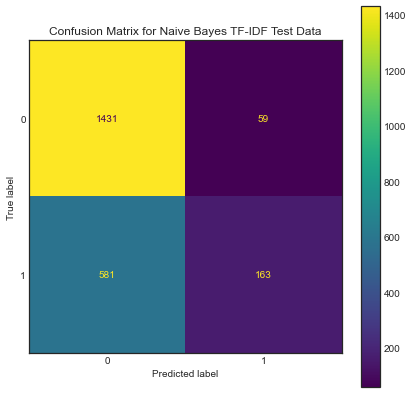

In [84]:
mnb_TF.confusion_matrix()

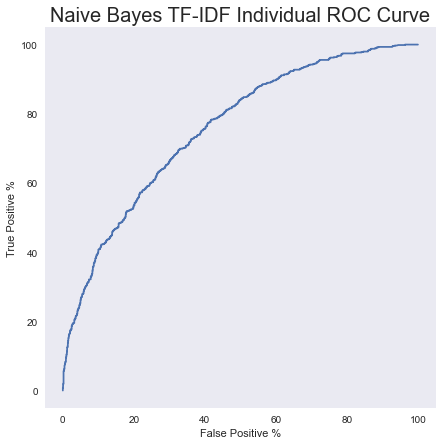

In [109]:
# Create the plot
fig, ax = plt.subplots(figsize=(7,7))
# get the predict_proba values
y_hat_hd = mnb_TF.y_pred_proba[:, 1]

# Get the FPR and TPR data
fpr, tpr, thresholds = roc_curve(mnb_TF.y_test, y_hat_hd)

ax.set_yticks([0,.2,.4,.6,.8,1])
ax.set_yticklabels([0,20,40,60,80,100])
ax.set_ylabel("True Positive %")

ax.set_xticks([0,.2,.4,.6,.8,1])
ax.set_xticklabels([0,20,40,60,80,100])
ax.set_xlabel("False Positive %")

# Plot the actual graph
ax.plot(fpr, tpr)
ax.set_title(f"{mnb_TF.name} Individual ROC Curve", fontsize=20)
plt.grid(False);

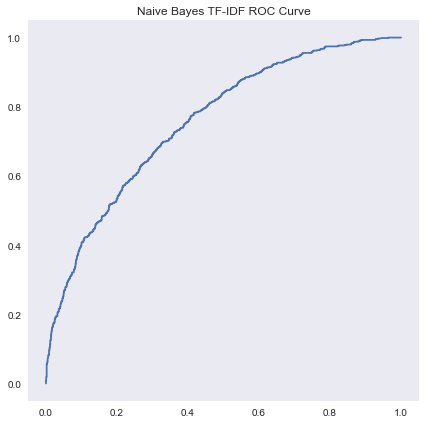

In [93]:
plt.style.use('seaborn')
mnb_TF.roc_curve()
plt.grid(False)

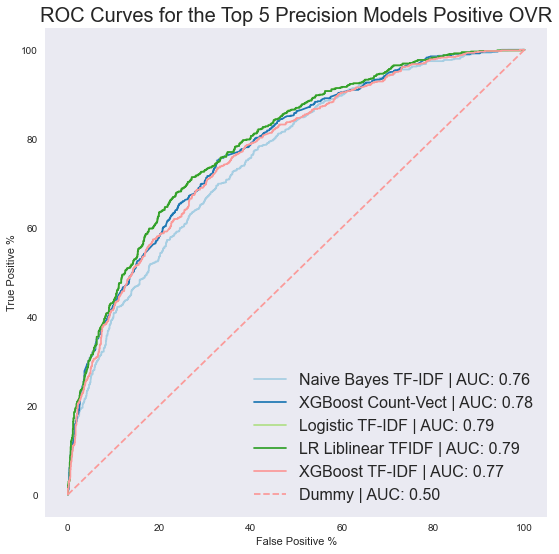

In [90]:
# Plotting the top 5 Models by accuracy against the dummy model
plt.style.use('seaborn')
# List of custom class model objects
top_models = [mnb_TF, XGB_C, lr_TF, LR_TFIDF_FINAL, XGB_TF]
color = sns.color_palette("Paired")
fig, ax = plt.subplots(figsize=(9,9))
for num, i in enumerate(top_models):
    y_hat_hd = i.y_pred_proba[:, 1]
    tpr, fpr, _ = roc_curve(i.y_test, y_hat_hd)
    ax.plot(tpr, fpr, color=color[num], label=f"{i.name} | AUC: {i.auc:.2f}")
ax.legend()
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_xticks([0, .2, .4, .6, .8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("True Positive %")
ax.set_xlabel("False Positive %")
ax.set_title("ROC Curves for the Top 5 Precision Models Positive OVR", fontsize=20)

y_hat_hd = dummy_0.y_pred_proba[:, 1]
tpr, fpr, _ = roc_curve(dummy_0.y_test, y_hat_hd)
ax.plot(tpr, fpr, color=color[num], label=f"{dummy_0.name} | AUC: {dummy_0.auc:.2f}", linestyle="--")
plt.grid(False)
ax.legend(bbox_to_anchor=(.5,.3))
plt.legend(fontsize=16);

# These models do not generalize precision well

In [207]:
positive_OVR.sort_values(by="train_prec", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,Random Forest TF-IDF Smote,0.808088,0.838186,0.767416,0.787890,0.427201,0.736347,0.638146,0.481183,0.548659,0.562301,0.783505
19,XGBoost TF-IDF Smote,0.781233,0.810622,0.730039,0.754413,0.454021,0.738138,0.632280,0.510753,0.565056,0.532899,0.775862
15,AdaBoost TF-IDF Smote,0.729417,0.750523,0.679919,0.707788,0.683208,0.683527,0.524374,0.534946,0.529607,0.684970,0.728241
3,Logistic TF-IDF Smote,0.765447,0.747539,0.800796,0.772230,0.499237,0.733214,0.583900,0.692204,0.633456,0.536067,0.791996
4,Logistic Count Smote,0.754710,0.737353,0.782422,0.752863,0.530323,0.689794,0.530178,0.602151,0.563877,0.594250,0.750590


In [211]:
positive_OVR.iloc[[0]]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.666667,0.0,0.0,0.0,12.014551,0.666965,0.0,0.0,0.0,12.003795,0.5


# NEGATIVE

# NEGATIVE

# NEGATIVE

# FOR NEGATIVE ONE VS REST DATA

In [170]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.936139,0.000000,0.000000,0.000000,2.301800,0.936437,0.000000,0.000000,0.000000,2.291047,0.500000
1,Logistic TF-IDF,0.935840,0.200000,0.002353,0.004651,0.193716,0.937780,0.800000,0.028169,0.054422,0.188002,0.841314
2,Logistic Count-Vect,0.938526,0.585377,0.137811,0.220956,0.184884,0.943151,0.659574,0.218310,0.328042,0.178534,0.846313
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
5,Naive Bayes TF-IDF,0.936139,0.000000,0.000000,0.000000,0.297099,0.936437,0.000000,0.000000,0.000000,0.293382,0.805507
6,Naive Bayes Count-Vect,0.918084,0.265617,0.161286,0.199881,0.414558,0.937780,0.534884,0.161972,0.248649,0.345802,0.834369
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
8,Naive Bayes Count Smote,0.910905,0.889296,0.938004,0.911569,0.354527,0.879588,0.234310,0.394366,0.293963,0.393100,0.787817
9,Random Forest TF-IDF,0.940019,0.651043,0.130862,0.216136,0.331604,0.944047,0.774194,0.169014,0.277457,0.279951,0.822372


In [172]:
Model.model_df.sort_values(by="test_recall",ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
16,AdaBoost Count Smote,0.841093,0.806711,0.895606,0.847921,0.662120,0.780215,0.141684,0.485915,0.219396,0.663307,0.733293
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
8,Naive Bayes Count Smote,0.910905,0.889296,0.938004,0.911569,0.354527,0.879588,0.234310,0.394366,0.293963,0.393100,0.787817


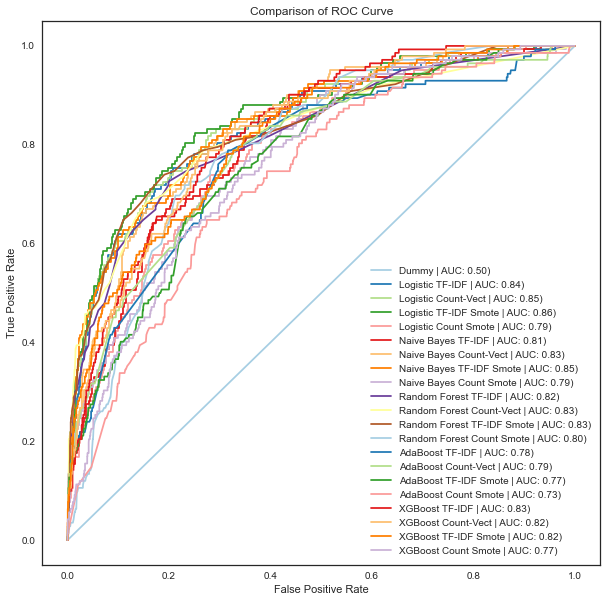

In [173]:
lr_C.compare_roc_curve()

### Grid Search For MNB TF-IDF with Smote
There is clear separation between this model and the rest of the field in terms of recall. 

In [175]:
type(mnb_tfidf_smote)

sklearn.naive_bayes.MultinomialNB

In [174]:
for i in mnb_tfidf_smote.get_params().keys():
    print(i)

alpha
class_prior
fit_prior
force_alpha


### Because we want to emphasize recall...

In [ ]:
MultinomialNB()

In [179]:
from sklearn.metrics import make_scorer
scorer = make_scorer(recall_score)

In [180]:
y_train.value_counts()

0    6274
1     428
Name: OVR-Negative, dtype: int64

In [182]:
from sklearn.model_selection import GridSearchCV

params = {"alpha": [1, .75, .5],
         "class_prior":[None, [6274/(6274+428), 428/(6274+428)]],
         "fit_prior": [False, True],
         "force_alpha": [False, True]}

scorer = make_scorer(recall_score)

grid_mnb = GridSearchCV(mnb_tfidf_smote, param_grid=params, scoring=scorer, n_jobs=4, verbose=2)


grid_mnb.fit(X_train_smote_tfidf, y_smote_tfidf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [1, 0.75, 0.5],
                         'class_prior': [None,
                                         [0.9361384661295136,
                                          0.06386153387048642]],
                         'fit_prior': [False, True],
                         'force_alpha': [False, True]},
             scoring=make_scorer(recall_score), verbose=2)

In [184]:
grid_mnb.best_params_

{'alpha': 0.5, 'class_prior': None, 'fit_prior': False, 'force_alpha': False}

In [185]:
recall_score(y_test, grid_mnb.best_estimator_.predict(X_test_tfidf))

0.5985915492957746

In [188]:
type(grid_mnb.best_estimator_)

sklearn.naive_bayes.MultinomialNB

In [189]:
GRID_BAYES = Model("Grid Searched MNB TF-IDF/SMOTE", grid_mnb.best_estimator_, tfidf, X_train_smote_tfidf, X_test_tfidf, y_smote_tfidf, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.4s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


As you can see, this scoring method improved the recall for the test group, however, the recall score for the test data actually got measurably worse. 

In [190]:
Model.model_df.sort_values(by="test_recall",ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
21,Grid Searched MNB TF-IDF/SMOTE,0.930348,0.884845,0.989480,0.934239,0.211753,0.879588,0.286195,0.598592,0.387244,0.321193,0.836665
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
16,AdaBoost Count Smote,0.841093,0.806711,0.895606,0.847921,0.662120,0.780215,0.141684,0.485915,0.219396,0.663307,0.733293
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059


In [191]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.936139,0.000000,0.000000,0.000000,2.301800,0.936437,0.000000,0.000000,0.000000,2.291047,0.500000
1,Logistic TF-IDF,0.935840,0.200000,0.002353,0.004651,0.193716,0.937780,0.800000,0.028169,0.054422,0.188002,0.841314
2,Logistic Count-Vect,0.938526,0.585377,0.137811,0.220956,0.184884,0.943151,0.659574,0.218310,0.328042,0.178534,0.846313
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
5,Naive Bayes TF-IDF,0.936139,0.000000,0.000000,0.000000,0.297099,0.936437,0.000000,0.000000,0.000000,0.293382,0.805507
6,Naive Bayes Count-Vect,0.918084,0.265617,0.161286,0.199881,0.414558,0.937780,0.534884,0.161972,0.248649,0.345802,0.834369
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
8,Naive Bayes Count Smote,0.910905,0.889296,0.938004,0.911569,0.354527,0.879588,0.234310,0.394366,0.293963,0.393100,0.787817
9,Random Forest TF-IDF,0.940019,0.651043,0.130862,0.216136,0.331604,0.944047,0.774194,0.169014,0.277457,0.279951,0.822372


In [192]:
negative_OVR = Model.model_df.copy()

In [193]:
negative_OVR.to_csv("/Users/samalainabayeva/Desktop/Water Project CSVs/negative_OVR.csv")

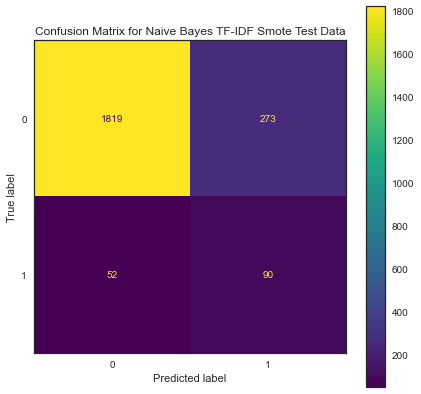

In [196]:
mnb_TF_S.confusion_matrix()

In [204]:
type(lr_C_S), lr_C_S.name

(__main__.Model, 'Logistic Count Smote')

In [ ]:
top_models = [mnb_TF_S, GRID_BAYES, lr_TF_S, ADA_C_S, lr_C_S]

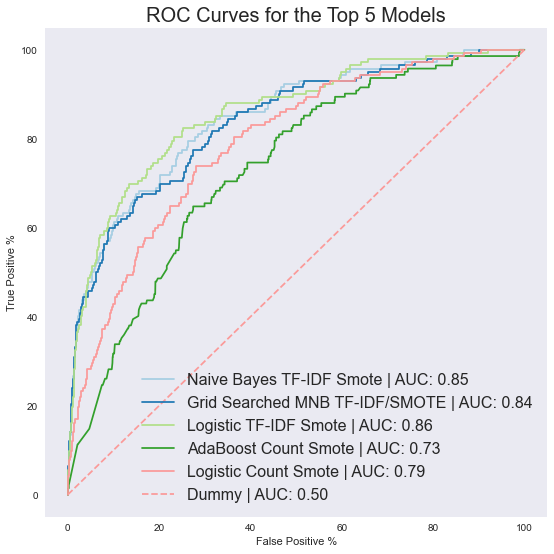

In [205]:
# Plotting the top 5 Models by accuracy against the dummy model
plt.style.use('seaborn')
# List of custom class model objects
top_models = [mnb_TF_S, GRID_BAYES, lr_TF_S, ADA_C_S, lr_C_S]
color = sns.color_palette("Paired")
fig, ax = plt.subplots(figsize=(9,9))
for num, i in enumerate(top_models):
    y_hat_hd = i.y_pred_proba[:, 1]
    tpr, fpr, _ = roc_curve(i.y_test, y_hat_hd)
    ax.plot(tpr, fpr, color=color[num], label=f"{i.name} | AUC: {i.auc:.2f}")
ax.legend()
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_xticks([0, .2, .4, .6, .8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("True Positive %")
ax.set_xlabel("False Positive %")
ax.set_title("ROC Curves for the Top 5 Models", fontsize=20)

y_hat_hd = dummy_0.y_pred_proba[:, 1]
tpr, fpr, _ = roc_curve(dummy_0.y_test, y_hat_hd)
ax.plot(tpr, fpr, color=color[num], label=f"{dummy_0.name} | AUC: {dummy_0.auc:.2f}", linestyle="--")
plt.grid(False)
ax.legend(bbox_to_anchor=(.5,.3))
plt.legend(fontsize=16);

In [206]:
Model.model_df.sort_values(by="test_recall",ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
7,Naive Bayes TF-IDF Smote,0.918234,0.868060,0.986451,0.923464,0.247666,0.854521,0.247934,0.633803,0.356436,0.354585,0.845245
21,Grid Searched MNB TF-IDF/SMOTE,0.930348,0.884845,0.989480,0.934239,0.211753,0.879588,0.286195,0.598592,0.387244,0.321193,0.836665
3,Logistic TF-IDF Smote,0.953858,0.922054,0.991553,0.955532,0.237465,0.904208,0.348739,0.584507,0.436842,0.275156,0.856943
16,AdaBoost Count Smote,0.841093,0.806711,0.895606,0.847921,0.662120,0.780215,0.141684,0.485915,0.219396,0.663307,0.733293
4,Logistic Count Smote,0.923337,0.908300,0.941512,0.922440,0.228525,0.876455,0.227642,0.394366,0.288660,0.294233,0.789059
